<a href="https://colab.research.google.com/github/FarwaSiddiqui/ECG-based-Arrythmia-detection/blob/Arrythmia-detection/CNN1d_Experiment_01_MIT_BIH_physionet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

The following notebook demonstrates the pre-processing and training of two MIT_BIH databases downloaded from physionet.org and Kaggle. It also concludes the key differences between two datasets. In this experiment, batch size, number of epochs, and learning rate were fixed, while other hyperparameters were optimized using Optuna.

### Importing Necessary Libraries


In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import os
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score


import optuna
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Datasetscomparision/')
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Datasetscomparision


In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-07-12 15:18:39 (2.02 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-07-12 15:18:39--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   688KB/s    in 2.8s    

2025-07-12 15:18:42 (688 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-07-12 15:18:42--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

In [ ]:
!pip install wfdb

In [ ]:
os.chdir('/content/drive/MyDrive/Datasetscomparision/')

# ***This is about dataset downloaded directly from Physionet***

In [ ]:
import wfdb

# Path to the record (excluding extension)
record_path = 'physionet.org/files/mitdb/1.0.0/101'

# Read the header and signal
record = wfdb.rdrecord(record_path)
print("Header (.hea) information:")
print(record.__dict__)


Header (.hea) information:
{'record_name': '101', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['75 F 1011 654 x1', 'Diapres'], 'sig_name': ['MLII', 'V1'], 'p_signal': array([[-0.345, -0.16 ],
       [-0.345, -0.16 ],
       [-0.345, -0.16 ],
       ...,
       [-0.295, -0.11 ],
       [-0.29 , -0.11 ],
       [ 0.   ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['101.dat', '101.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [955, 992], 'checksum': [29832, 19589], 'block_size': [0, 0]}


In [ ]:
# Read annotation (from .atr file)
annotation = wfdb.rdann(record_path, 'atr')
print("Annotation (.atr) sample indices and labels:")
print(list(zip(annotation.sample[:20], annotation.symbol[:20])))  # Print first 20 annotations


Annotation (.atr) sample indices and labels:
[(np.int64(7), '+'), (np.int64(83), 'N'), (np.int64(396), 'N'), (np.int64(711), 'N'), (np.int64(1032), 'N'), (np.int64(1368), 'N'), (np.int64(1712), 'N'), (np.int64(2036), 'N'), (np.int64(2349), 'N'), (np.int64(2662), 'N'), (np.int64(2972), 'N'), (np.int64(3301), 'N'), (np.int64(3631), 'N'), (np.int64(3960), 'N'), (np.int64(4283), 'N'), (np.int64(4609), 'N'), (np.int64(4928), 'N'), (np.int64(5241), 'N'), (np.int64(5569), 'N'), (np.int64(5898), 'N')]


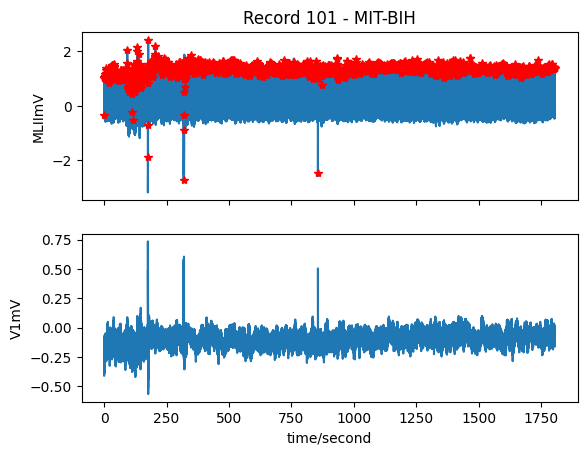

In [ ]:
# Plot signal with annotation marks
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 101 - MIT-BIH')


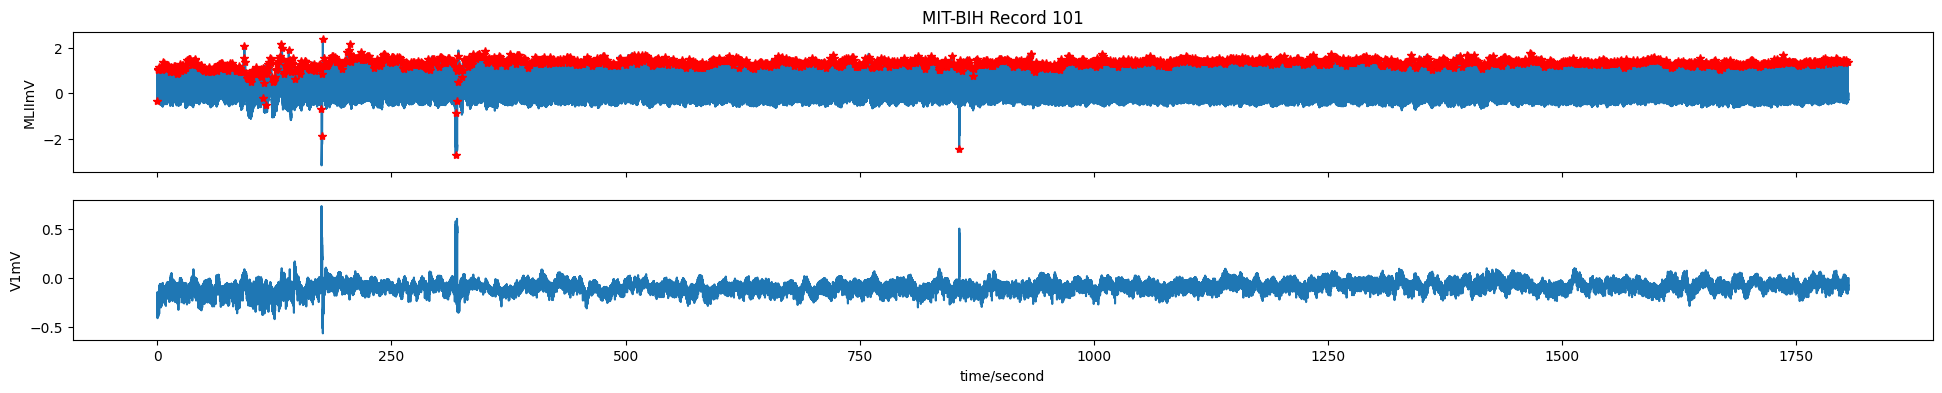

In [ ]:
wfdb.plot_wfdb(
    record=record,
    annotation=annotation,
    title='MIT-BIH Record 101',
    figsize=(24, 4)  # Width x Height in inches
)

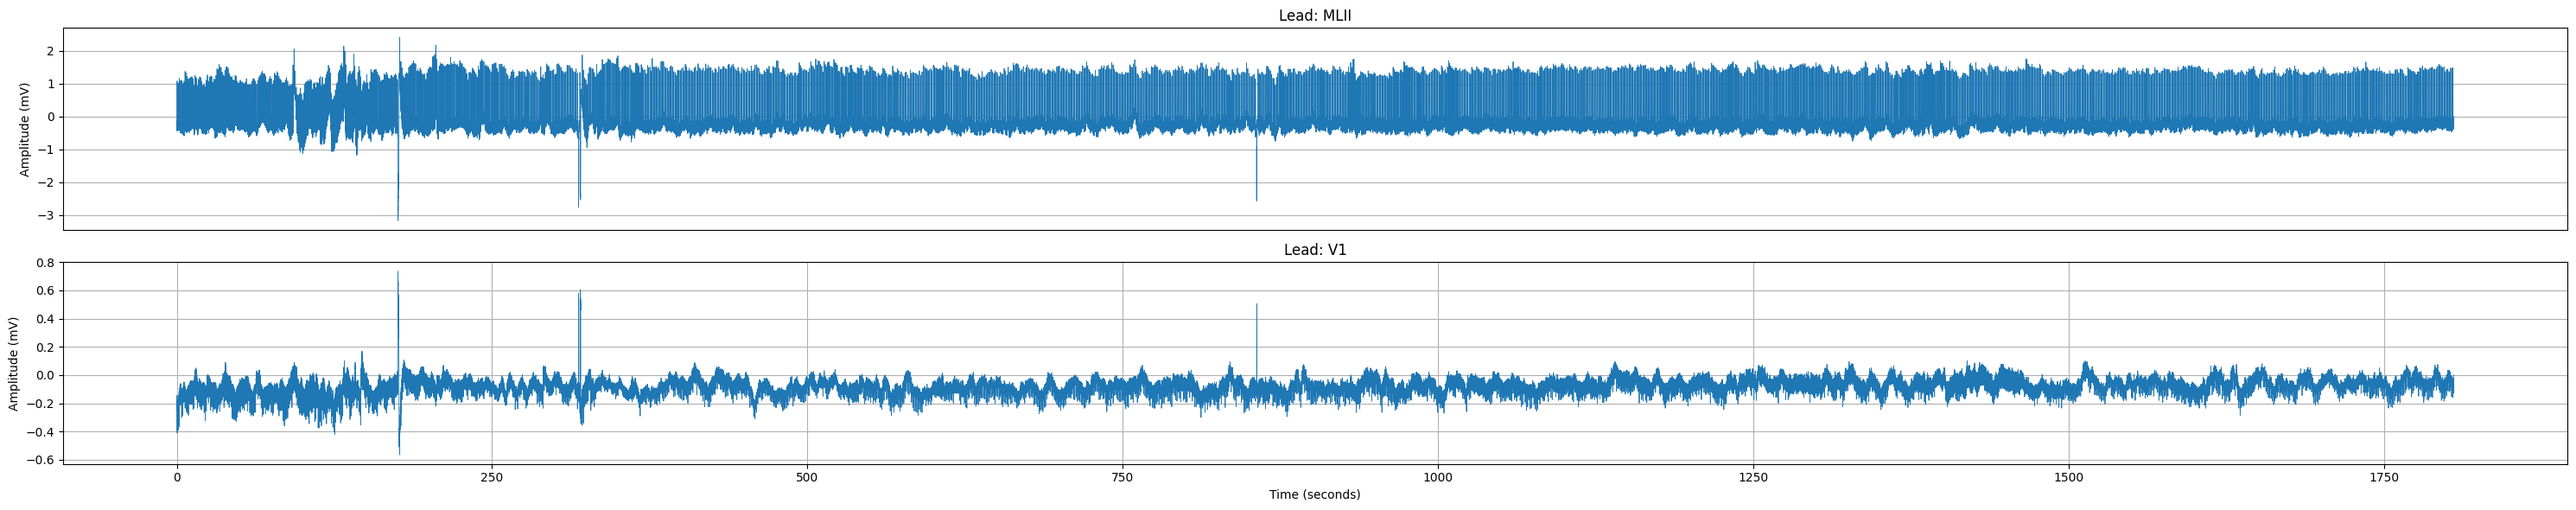

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Load the record (no need for annotation unless you want it)
record_path = 'physionet.org/files/mitdb/1.0.0/101'
record = wfdb.rdrecord(record_path)

# Extract signal data and metadata
signal = record.p_signal
leads = record.sig_name
num_leads = len(leads)
signal_length = signal.shape[0]
fs = record.fs  # Sampling frequency (360 Hz)

# Create time axis in seconds
time = [i / fs for i in range(signal_length)]

# Plot each lead on a separate subplot
plt.figure(figsize=(30, 6))  # Wide and readable

for i in range(num_leads):
    plt.subplot(num_leads, 1, i + 1)
    plt.plot(time, signal[:, i], linewidth=0.6)
    plt.title(f"Lead: {leads[i]}")
    plt.ylabel("Amplitude (mV)")
    if i == num_leads - 1:
        plt.xlabel("Time (seconds)")
    else:
        plt.xticks([])  # Hide x-axis ticks for all but last

    plt.grid(True)

plt.tight_layout()
plt.show()


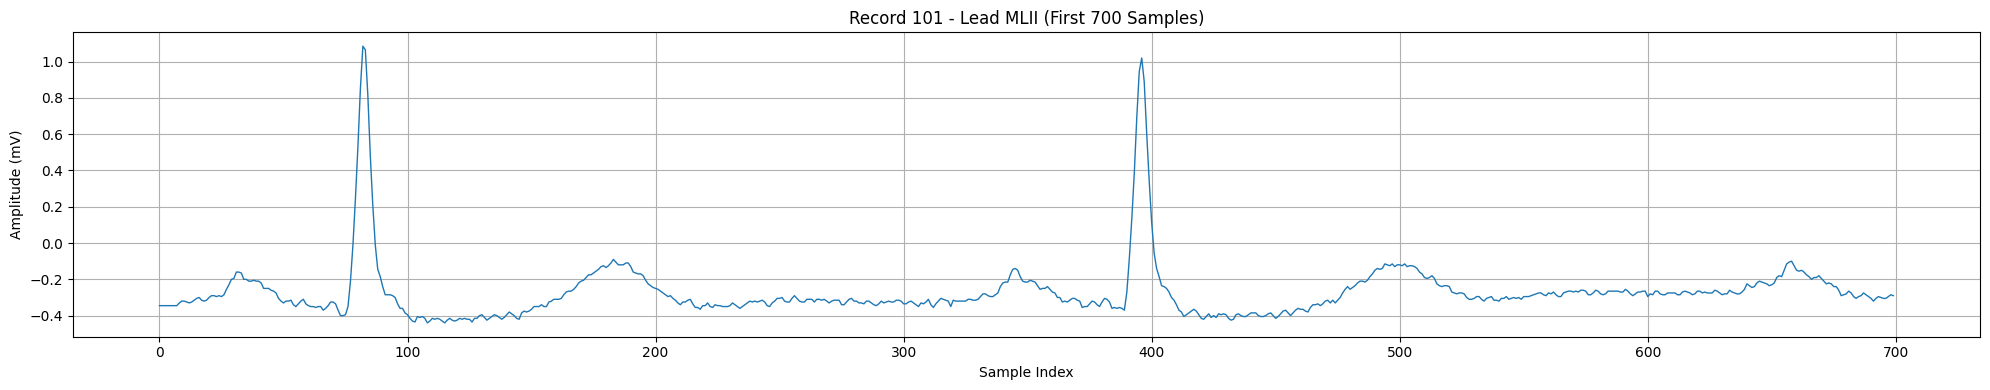

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Load record 101
record_path = 'physionet.org/files/mitdb/1.0.0/101'
record = wfdb.rdrecord(record_path)

# Extract signal and lead names
signal = record.p_signal
leads = record.sig_name

# Choose Lead MLII (usually at index 0)
lead_index = leads.index('MLII')  # Confirm MLII is present
lead_signal = signal[:, lead_index]

# Plot the first 700 samples of MLII
plt.figure(figsize=(20, 4))
plt.plot(lead_signal[:700], linewidth=1)
plt.title("Record 101 - Lead MLII (First 700 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Raw signal array (2D NumPy array: shape = [n_samples, n_channels])
signal_data = record.p_signal
print("Signal shape:", signal_data.shape)

# Print first 10 samples of both channels
print("First 10 samples:")
print(signal_data[:10])


Signal shape: (650000, 2)
First 10 samples:
[[-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.33  -0.15 ]
 [-0.32  -0.145]]


In [ ]:
import wfdb
from scipy.signal import medfilt
from scipy import stats
import numpy as np

records = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109', '111', '112', '113', '114', '115', '116',
    '117', '118', '119', '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207', '208', '209', '210',
    '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Data path to downloaded PhysioNet MIT-BIH files
data_dir = '/content/drive/MyDrive/Datasetscomparision/physionet.org/files/mitdb/1.0.0/'

# Define settings
window_size = 180  # 180 before and 180 after = 360 samples
maximum_counting = 10000
classes = ['N', 'L', 'R', 'A', 'V']  # Target arrhythmia labels
count_classes = [0] * len(classes)

# Containers for dataset
X = []
y = []

# Process each record
for rec in records:
    try:
        rec_path = data_dir + rec
        record = wfdb.rdrecord(rec_path)
        annotation = wfdb.rdann(rec_path, 'atr')

        # Read and preprocess MLII lead
        signal = record.p_signal[:, 0]
        signal = medfilt(signal, kernel_size=5)  # Denoising
        signal = stats.zscore(signal)  # Normalization

        for i, pos in enumerate(annotation.sample):
            if pos > window_size and pos < len(signal) - window_size:
                label = annotation.symbol[i]
                if label in classes:
                    idx = classes.index(label)
                    if count_classes[idx] < maximum_counting:
                        beat = signal[pos - window_size: pos + window_size]
                        X.append(beat)
                        y.append(idx)
                        count_classes[idx] += 1

        print(f"✓ Processed record {rec}")

    except Exception as e:
        print(f"⚠️ Error processing record {rec}: {e}")

# Final dataset summary
print("✅ Beat extraction complete!")
print("Shape of X:", np.shape(X))
print("Shape of y:", np.shape(y))
print("Class counts:", dict(zip(classes, count_classes)))


✓ Processed record 100
✓ Processed record 101
✓ Processed record 102
✓ Processed record 103
✓ Processed record 104
✓ Processed record 105
✓ Processed record 106
✓ Processed record 107
✓ Processed record 108
✓ Processed record 109
✓ Processed record 111
✓ Processed record 112
✓ Processed record 113
✓ Processed record 114
✓ Processed record 115
✓ Processed record 116
✓ Processed record 117
✓ Processed record 118
✓ Processed record 119
✓ Processed record 121
✓ Processed record 122
✓ Processed record 123
✓ Processed record 124
✓ Processed record 200
✓ Processed record 201
✓ Processed record 202
✓ Processed record 203
✓ Processed record 205
✓ Processed record 207
✓ Processed record 208
✓ Processed record 209
✓ Processed record 210
✓ Processed record 212
✓ Processed record 213
✓ Processed record 214
✓ Processed record 215
✓ Processed record 217
✓ Processed record 219
✓ Processed record 220
✓ Processed record 221
✓ Processed record 222
✓ Processed record 223
✓ Processed record 228
✓ Processed

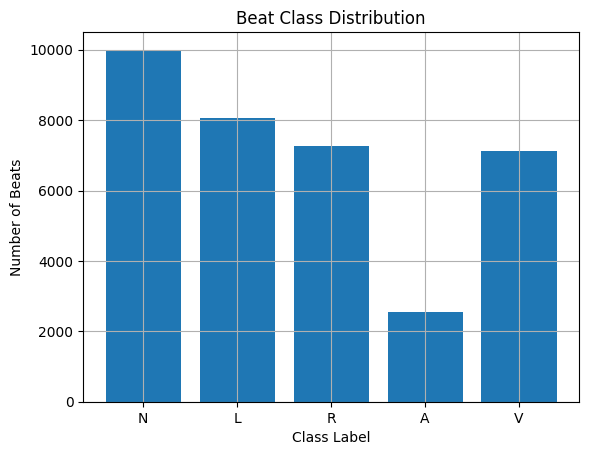

In [ ]:
import matplotlib.pyplot as plt

classes = ['N', 'L', 'R', 'A', 'V']
plt.bar(classes, [10000, 8071, 7254, 2546, 7129])
plt.title("Beat Class Distribution")
plt.ylabel("Number of Beats")
plt.xlabel("Class Label")
plt.grid(True)
plt.show()


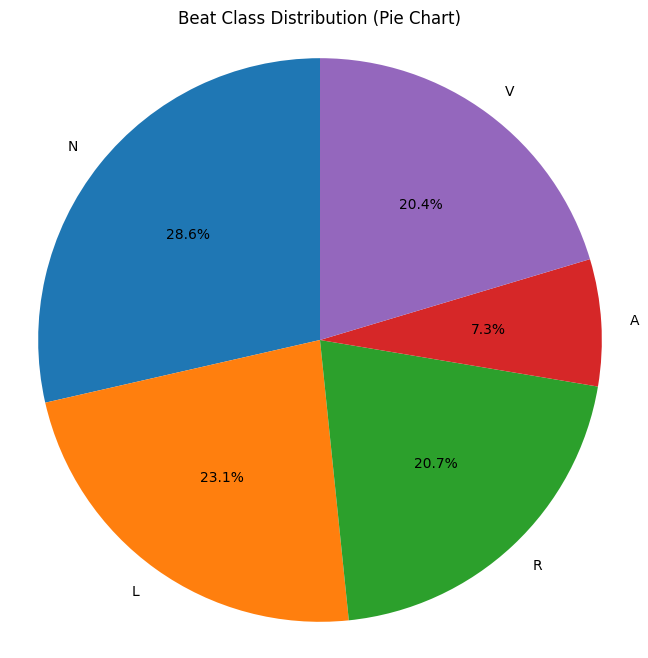

In [ ]:
import matplotlib.pyplot as plt

# Class labels and counts
classes = ['N', 'L', 'R', 'A', 'V']
counts = [10000, 8071, 7254, 2546, 7129]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title("Beat Class Distribution (Pie Chart)")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


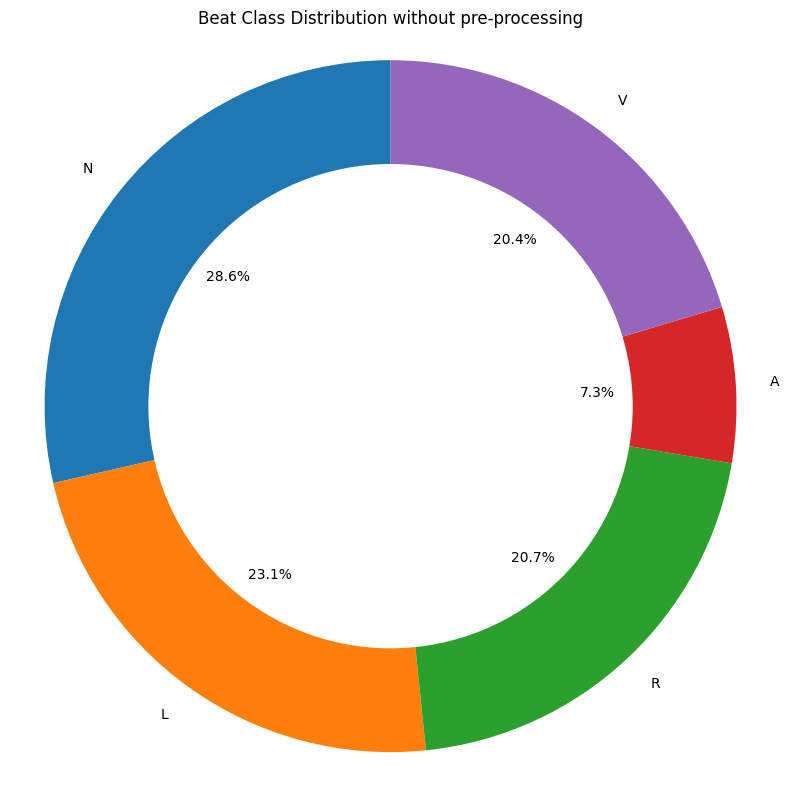

In [ ]:
import matplotlib.pyplot as plt

# Class labels and counts
classes = ['N', 'L', 'R', 'A', 'V']
counts = [10000, 8071, 7254, 2546, 7129]

# Create figure and pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=classes,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4)  # This creates the "donut" effect
)

# Add a white circle at the center (optional for full control)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the pie is drawn as a circle
ax.axis('equal')
plt.title("Beat Class Distribution without pre-processing")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

np.save('X_physionet_360.npy', np.array(X))
np.save('y_physionet_360.npy', np.array(y))

'''can be loaded later by following commands:
X = np.load('X_physionet_360.npy')
y = np.load('y_physionet_360.npy')'''

"can be loaded later by following commands:\nX = np.load('X_physionet_360.npy')\ny = np.load('y_physionet_360.npy')"

✓ Processed record 100


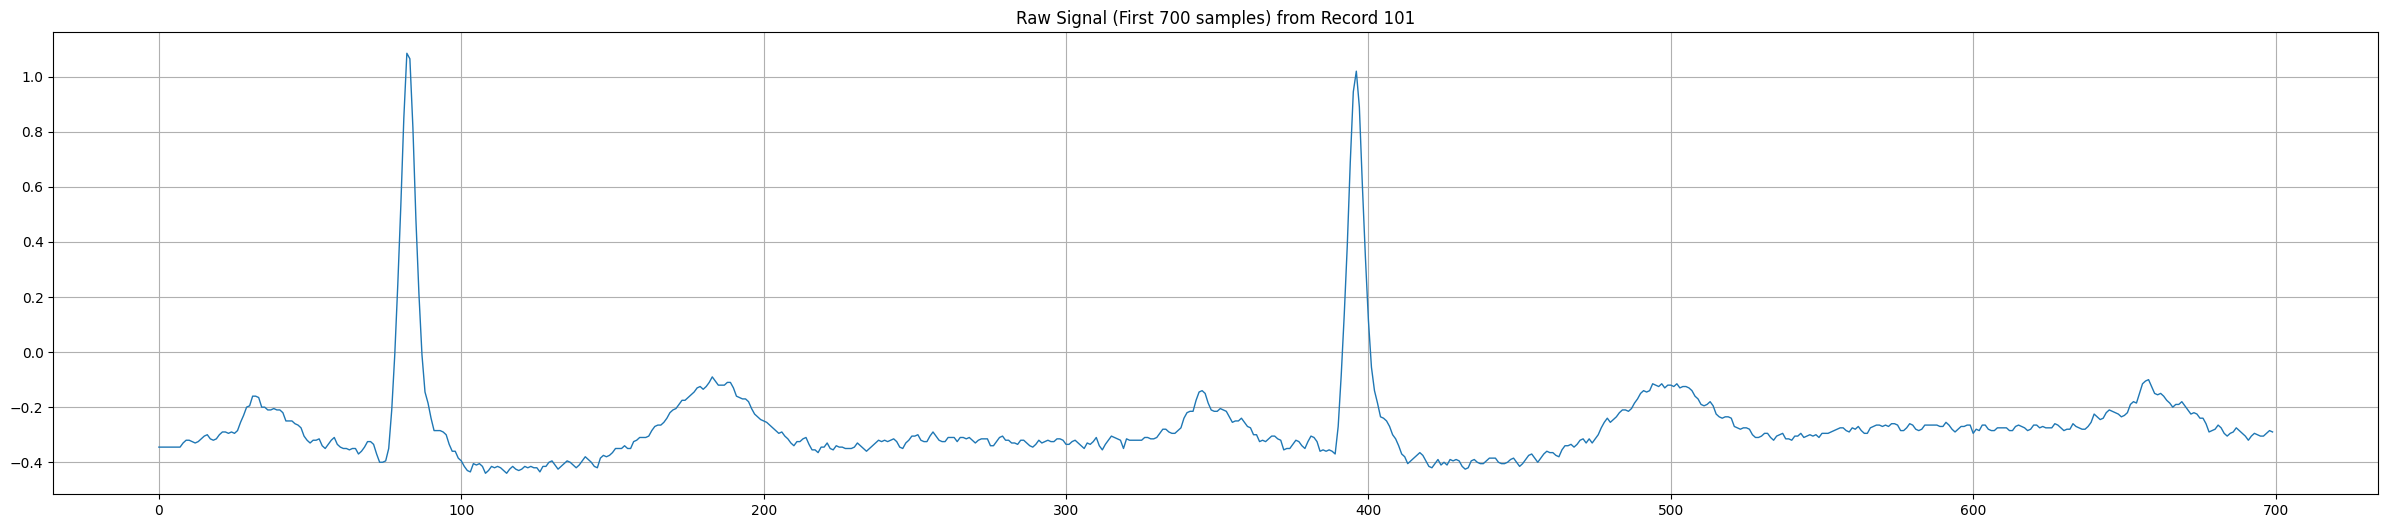

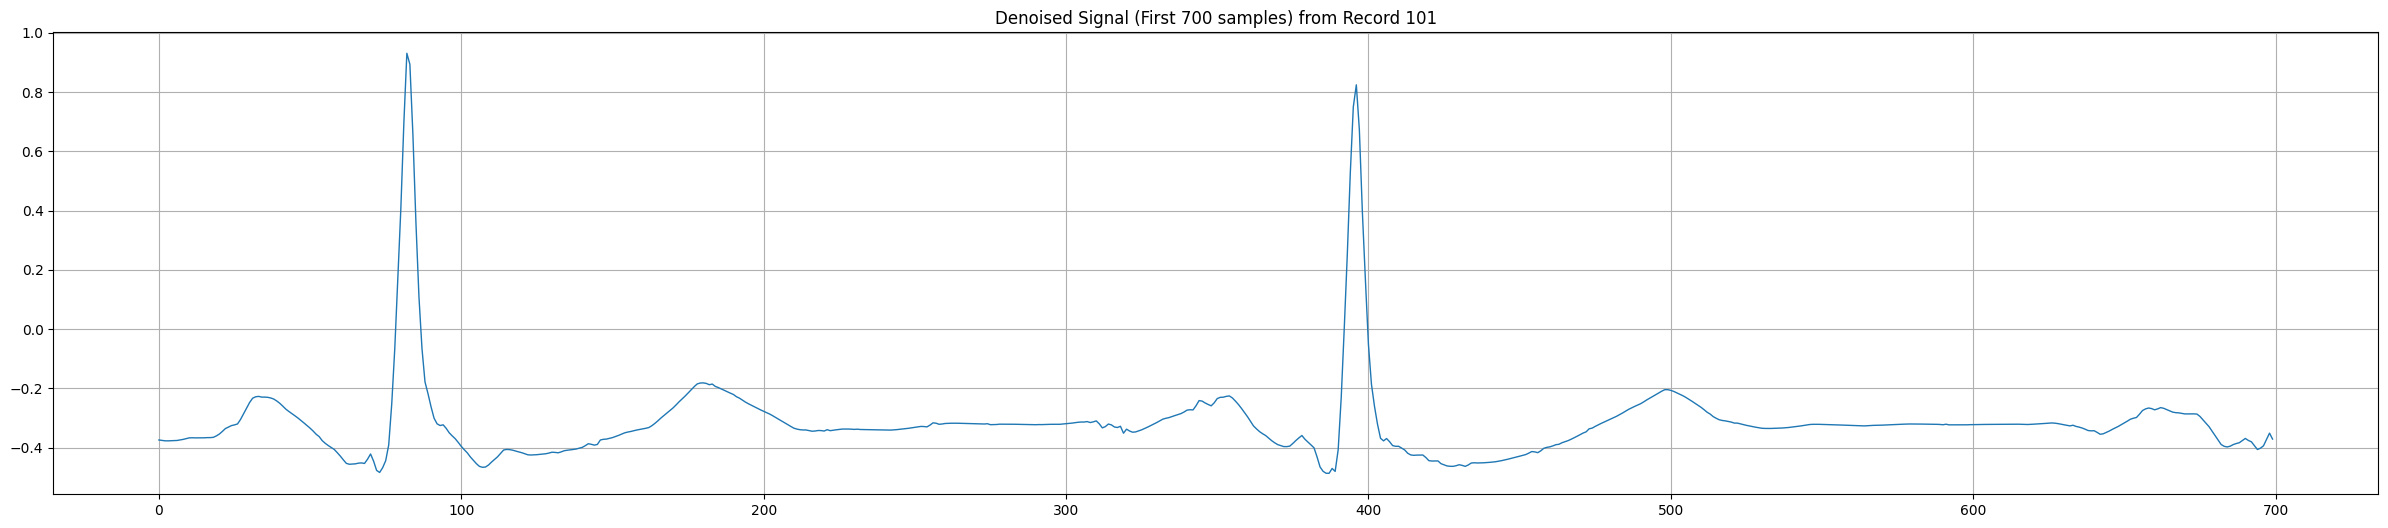

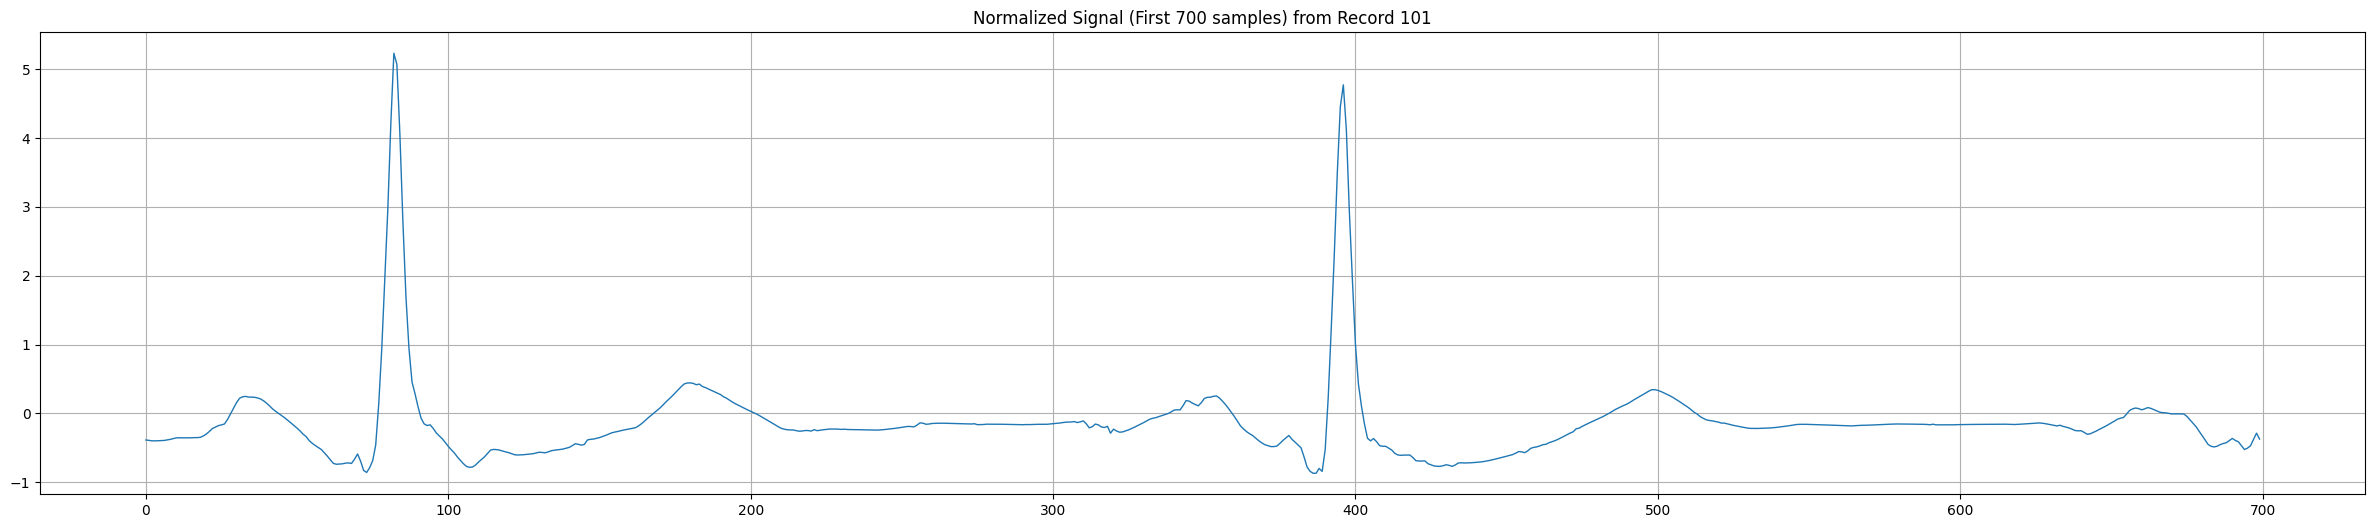

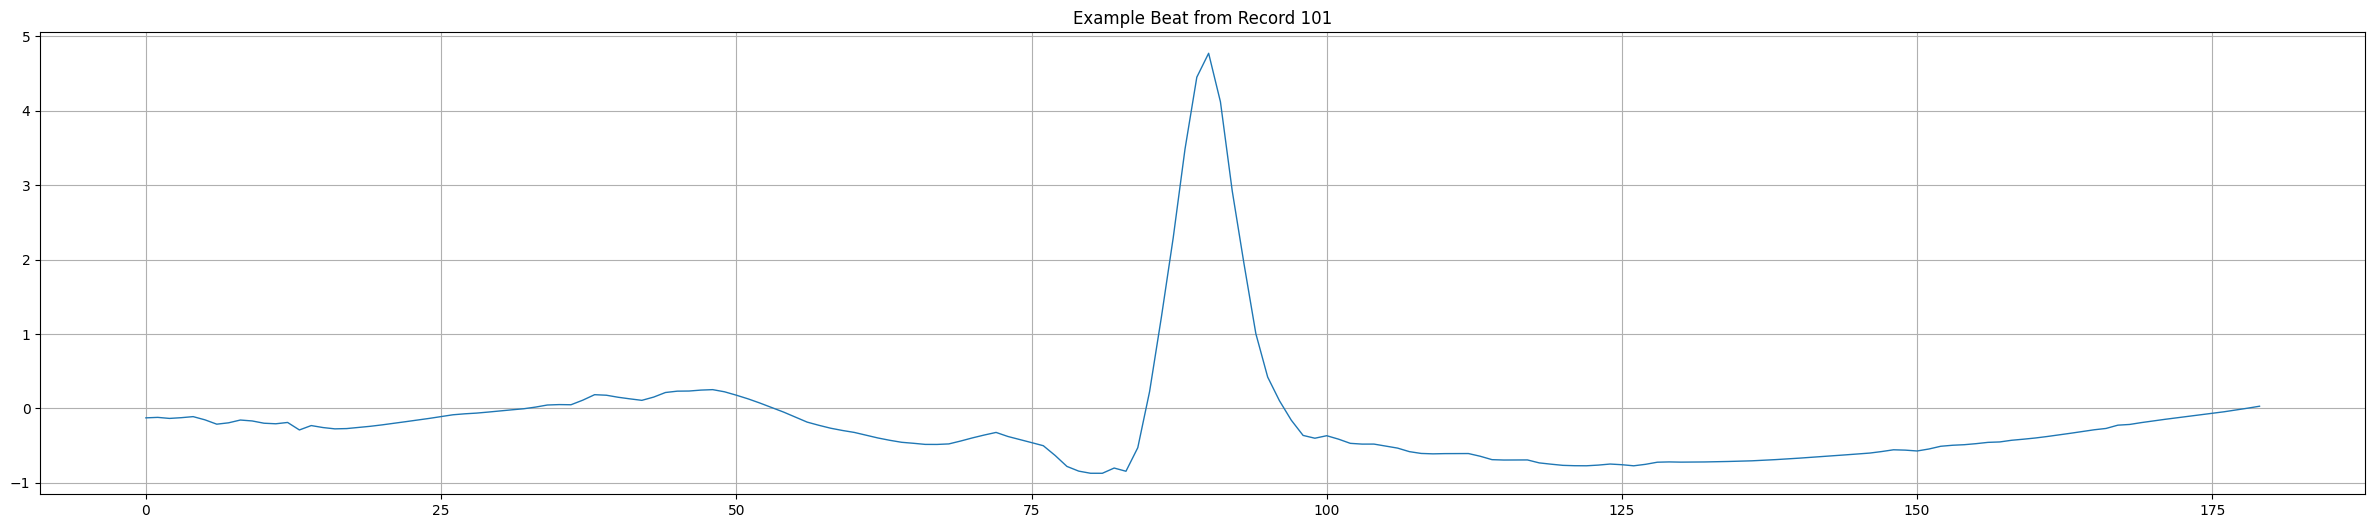

✓ Processed record 101
✓ Processed record 102
✓ Processed record 103
✓ Processed record 104
✓ Processed record 105
✓ Processed record 106
✓ Processed record 107
✓ Processed record 108
✓ Processed record 109
✓ Processed record 111
✓ Processed record 112
✓ Processed record 113
✓ Processed record 114
✓ Processed record 115
✓ Processed record 116
✓ Processed record 117
✓ Processed record 118
✓ Processed record 119
✓ Processed record 121
✓ Processed record 122
✓ Processed record 123
✓ Processed record 124
✓ Processed record 200
✓ Processed record 201
✓ Processed record 202
✓ Processed record 203
✓ Processed record 205
✓ Processed record 207
✓ Processed record 208
✓ Processed record 209
✓ Processed record 210
✓ Processed record 212
✓ Processed record 213
✓ Processed record 214
✓ Processed record 215
✓ Processed record 217
✓ Processed record 219
✓ Processed record 220
✓ Processed record 221
✓ Processed record 222
✓ Processed record 223
✓ Processed record 228
✓ Processed record 230
✓ Processed

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pywt

# PhysioNet record list
records = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109', '111', '112', '113', '114', '115', '116',
    '117', '118', '119', '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207', '208', '209', '210',
    '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Path to MIT-BIH WFDB data
base_path = '/content/drive/MyDrive/Datasetscomparision/physionet.org/files/mitdb/1.0.0/'

# Class labels of interest
classes = ['N', 'L', 'R', 'A', 'V']
count_classes = [0] * len(classes)

# Windowing and output lists
window_size = 90  # for 180-sample beat
X = []
y = []

# ---- Wavelet Denoising ----
def denoise(signal):
    wavelet = 'sym4'
    coeffs = pywt.wavedec(signal, wavelet, level=pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len))
    threshold = 0.04
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
    return pywt.waverec(coeffs, wavelet)[:len(signal)]


# ---- Loop Through Each Record ----
for r, rec in enumerate(records):
    try:
        rec_path = base_path + rec
        record = wfdb.rdrecord(rec_path)
        annotation = wfdb.rdann(rec_path, 'atr')

        # Get MLII lead (usually index 0)
        signal = record.p_signal[:, 0]

        # Plot raw signal for record 101
        if rec == '101':
            plt.title("Raw Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Denoise
        signal = denoise(signal)

        if rec == '101':
            plt.title("Denoised Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Z-score normalize
        signal = stats.zscore(signal)

        if rec == '101':
            plt.title("Normalized Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Extract beat windows from annotations
        example_beat_printed = False
        for i, pos in enumerate(annotation.sample):
            if pos < window_size or pos > (len(signal) - window_size):
                continue

            label = annotation.symbol[i]
            if label in classes:
                class_index = classes.index(label)
                count_classes[class_index] += 1

                beat = signal[pos - window_size:pos + window_size]

                # Plot one example beat from record 101
                if rec == '101' and not example_beat_printed:
                    plt.title("Example Beat from Record 101")
                    plt.plot(beat)
                    plt.show()
                    example_beat_printed = True

                X.append(beat)
                y.append(class_index)

        print(f"✓ Processed record {rec}")

    except Exception as e:
        print(f"⚠️ Error processing record {rec}: {e}")

# Final shape
print("✅ Beat extraction complete!")
print("Shape of X:", np.shape(X))
print("Shape of y:", np.shape(y))
print("Class counts:", dict(zip(classes, count_classes)))


In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
import pywt
import numpy as np

def denoise(signal):
    """
    Denoises an ECG signal using wavelet decomposition and thresholding.

    Parameters:
    - signal: 1D NumPy array of ECG values (e.g., from p_signal[:, 0])

    Returns:
    - datarec: The denoised signal (same length as input)
    """
    wavelet = 'sym4'
    w = pywt.Wavelet(wavelet)

    # Determine the maximum decomposition level
    maxlev = pywt.dwt_max_level(len(signal), w.dec_len)

    # Decompose the signal
    coeffs = pywt.wavedec(signal, wavelet, level=maxlev)

    # Apply soft thresholding to detail coefficients
    threshold = 0.04
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))

    # Reconstruct the denoised signal
    datarec = pywt.waverec(coeffs, wavelet)

    # Ensure the reconstructed signal matches the original length
    return datarec[:len(signal)]


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100038, 181)


180
0.0    75033
1.0     8073
2.0     7257
4.0     7129
3.0     2546
Name: count, dtype: int64


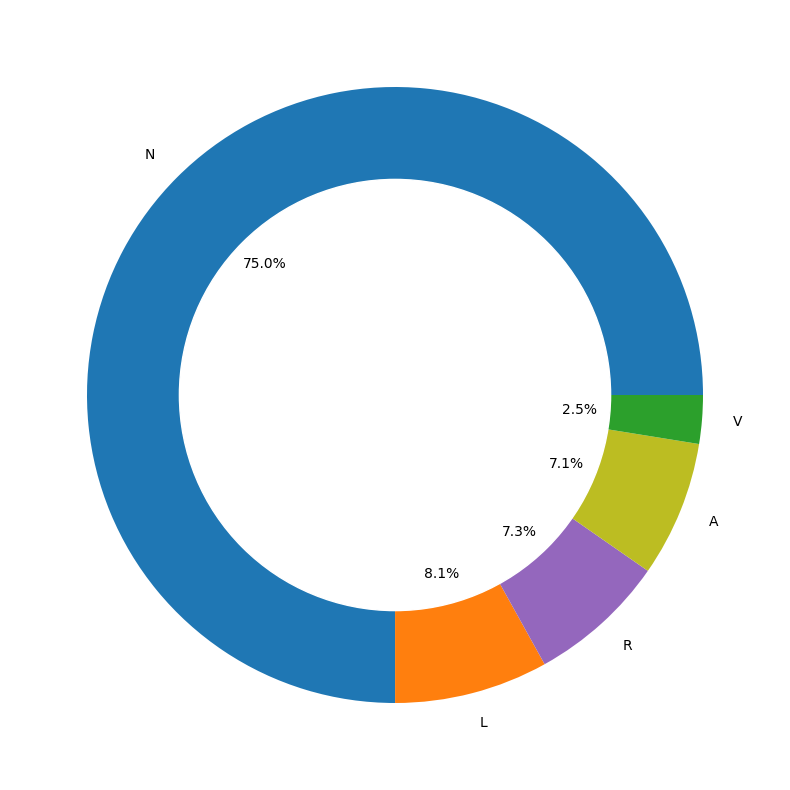

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

180
0.0    3000
1.0    3000
2.0    3000
3.0    3000
4.0    3000
Name: count, dtype: int64


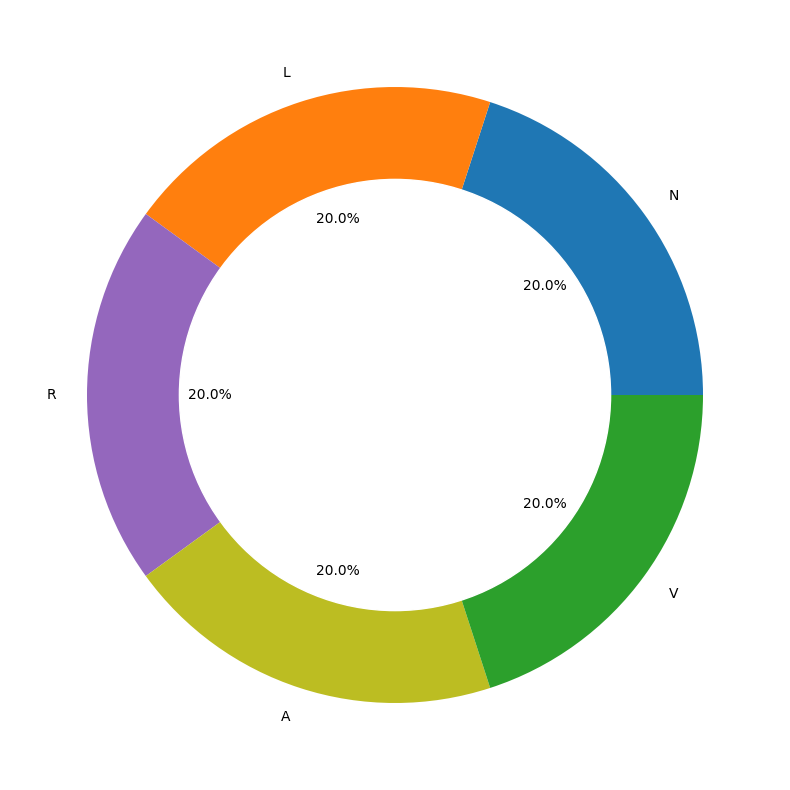

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# **Kaggle based MIT_BIH database**

### Matplotlib Settings

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

### 1. Preprocessing - Denoising the signal
This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [ ]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Preprocessing – Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                           |
|-----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm. |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.      |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.              |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.     |


In [ ]:
path = '/content/drive/My Drive/Readymade/input/archive/mitbih_database/'
#path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

### 3. Preprocessing - Segmentation into windows of 2000 sample points

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipython-input-13-3542894224.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipython-input-13-3542894224.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipython-input-13-3542894224.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipython-input-13-3542894224.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


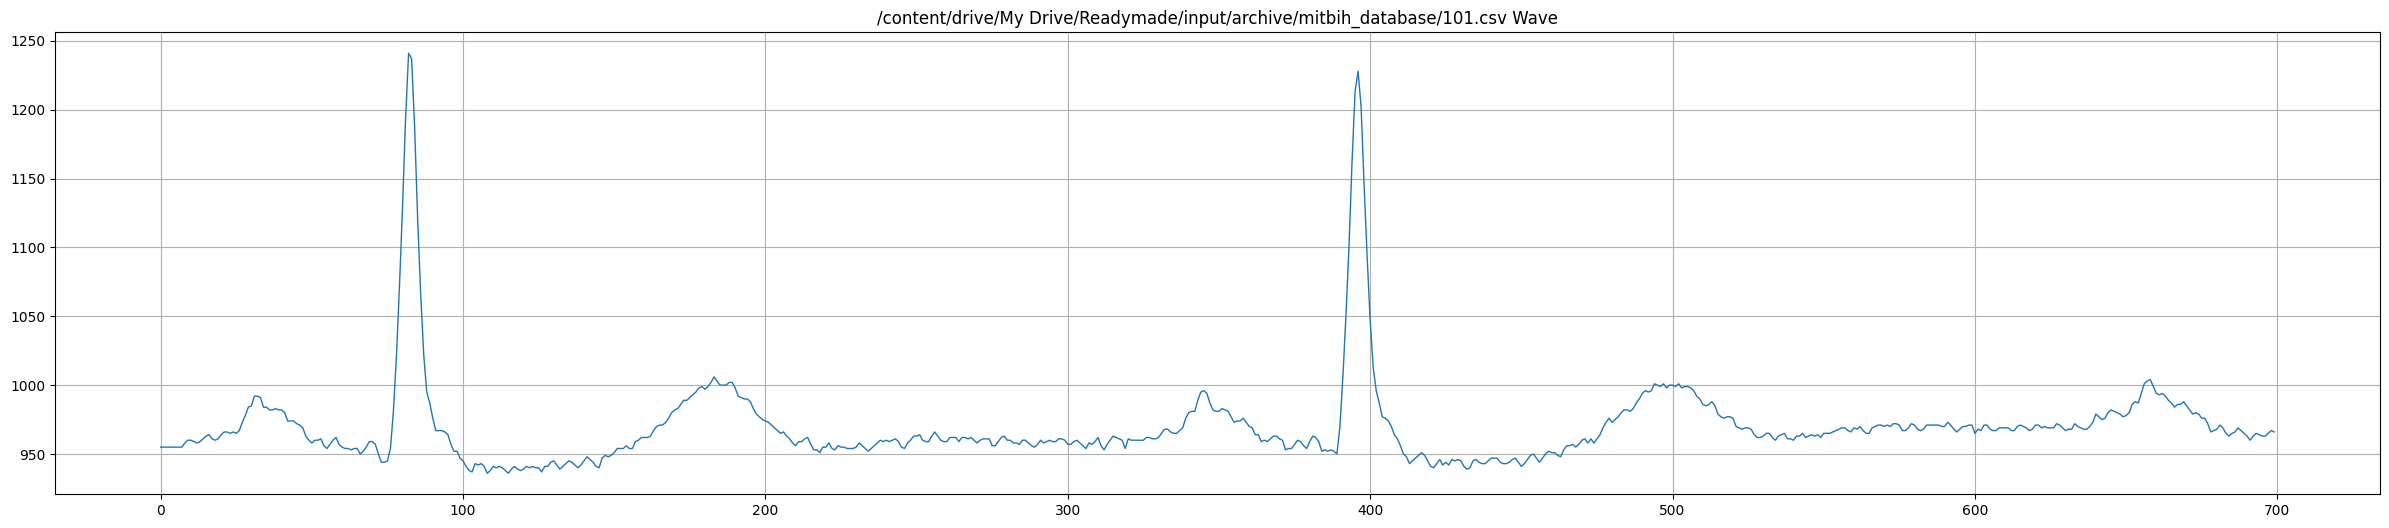

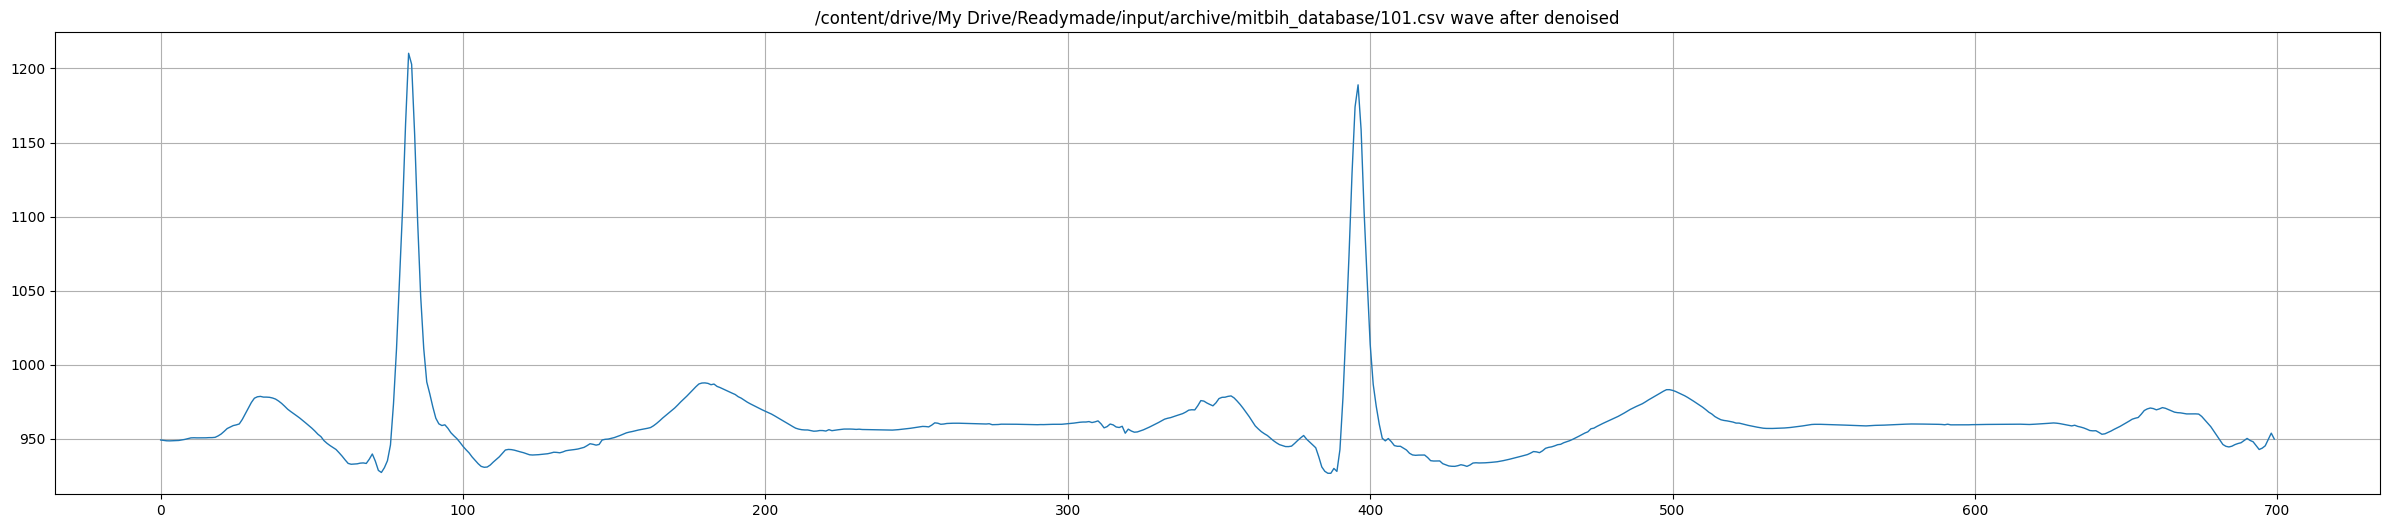

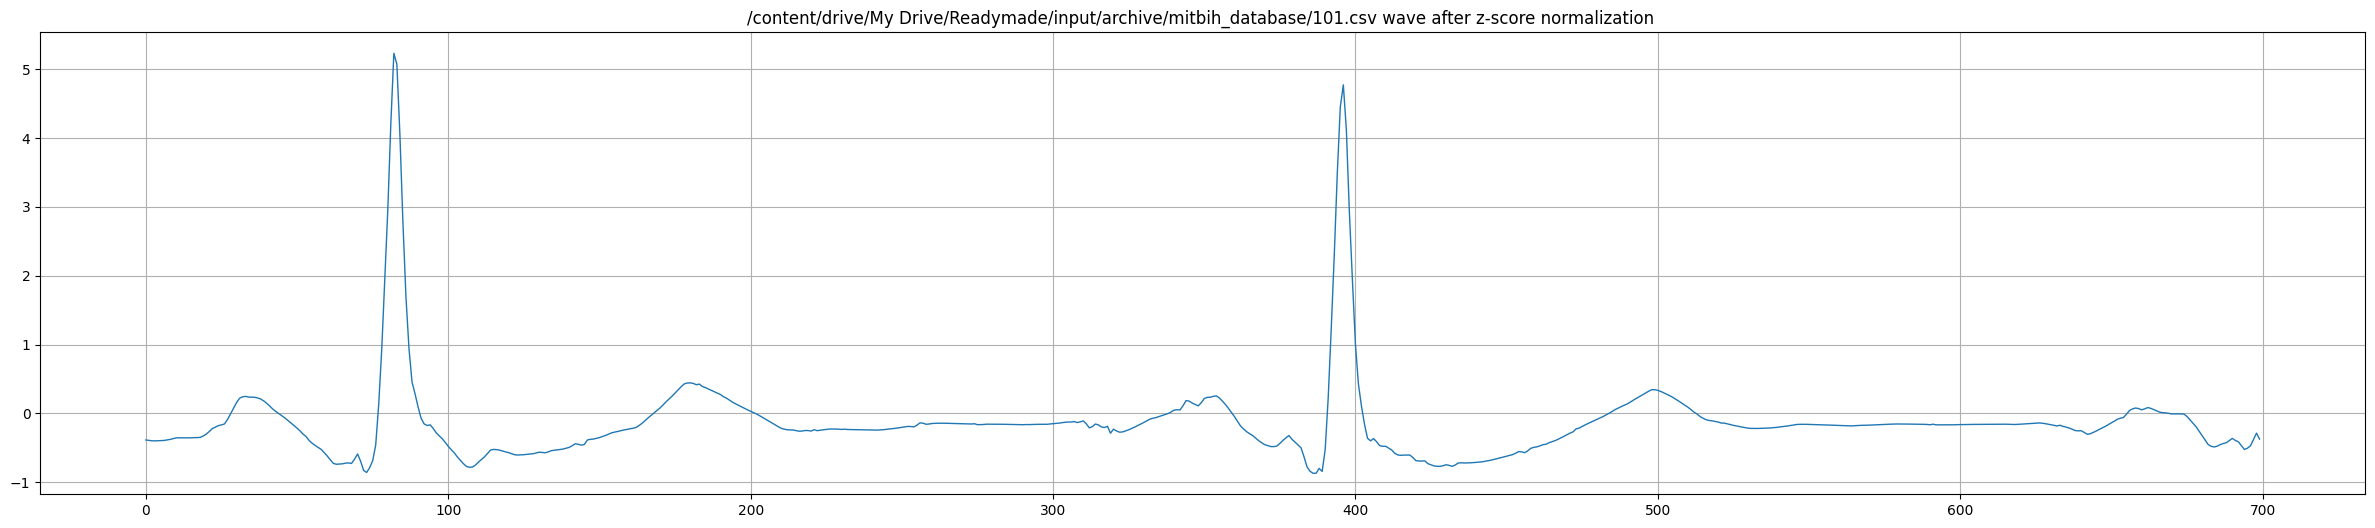

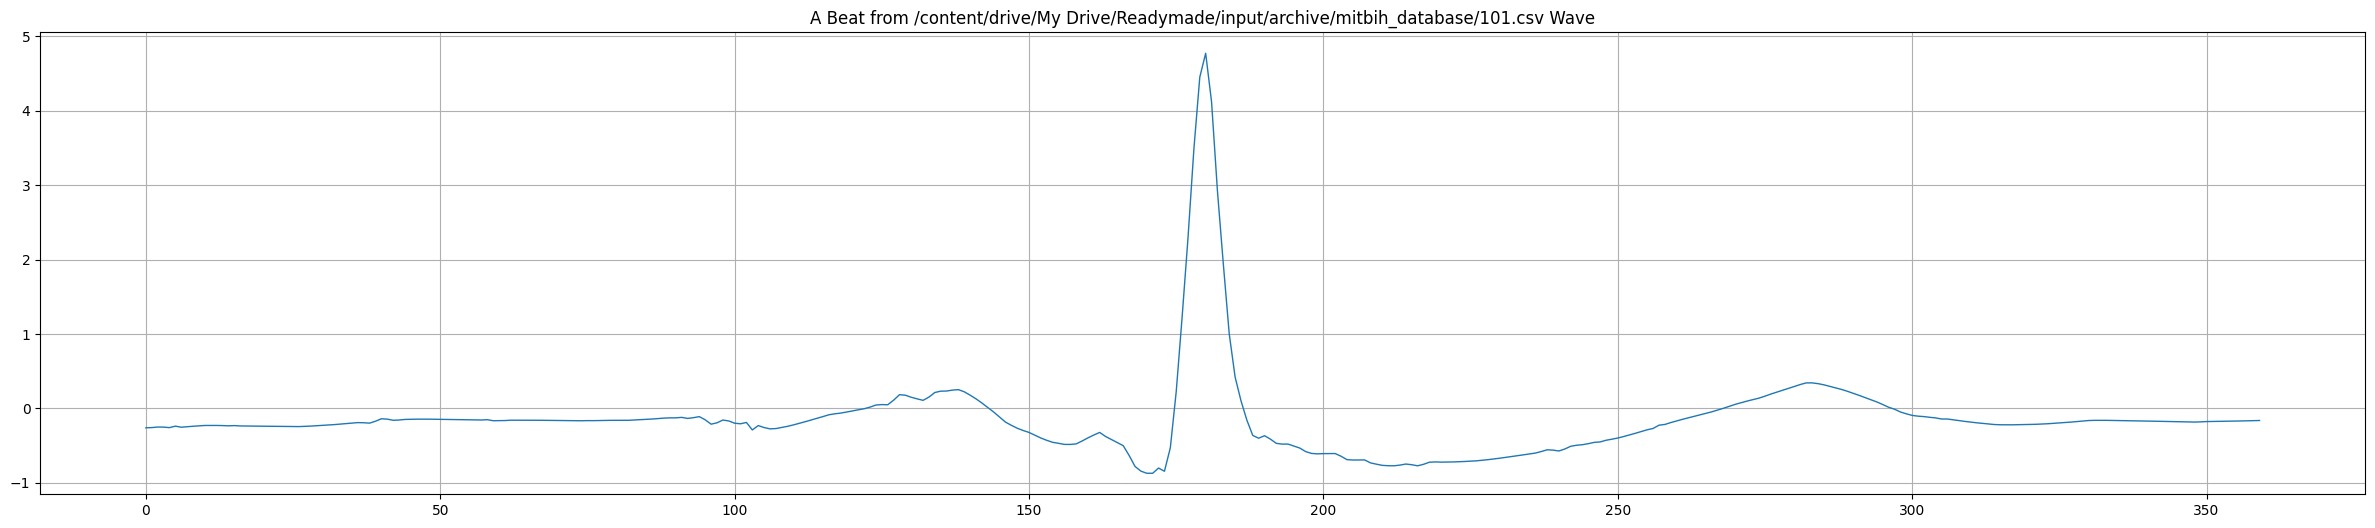

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r is 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


### 4. Preprocessing - Balancing the classes with each class having 3000 segments

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


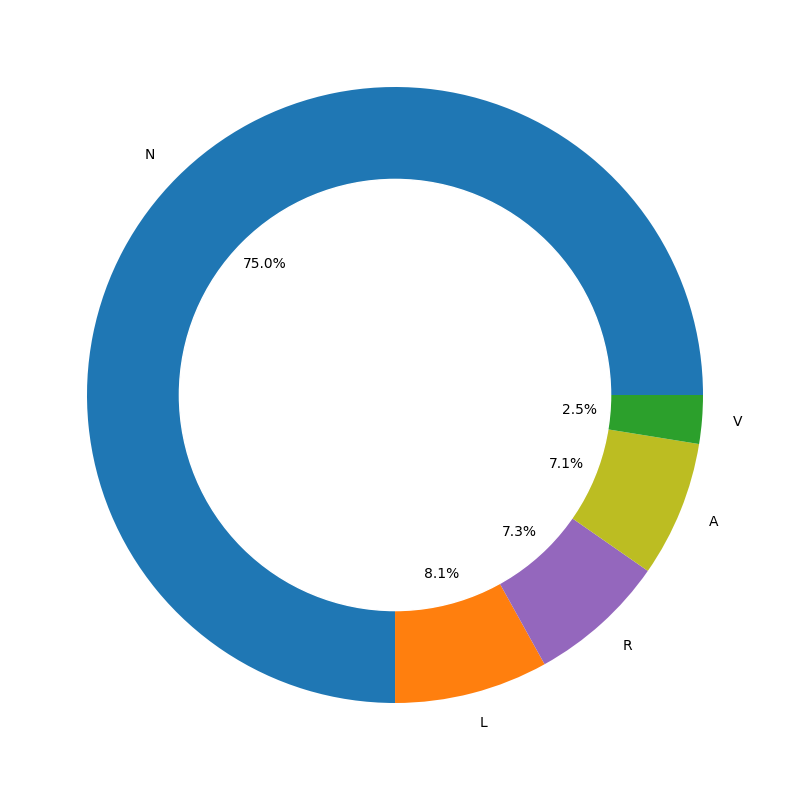

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    3000
1.0    3000
2.0    3000
3.0    3000
4.0    3000
Name: count, dtype: int64


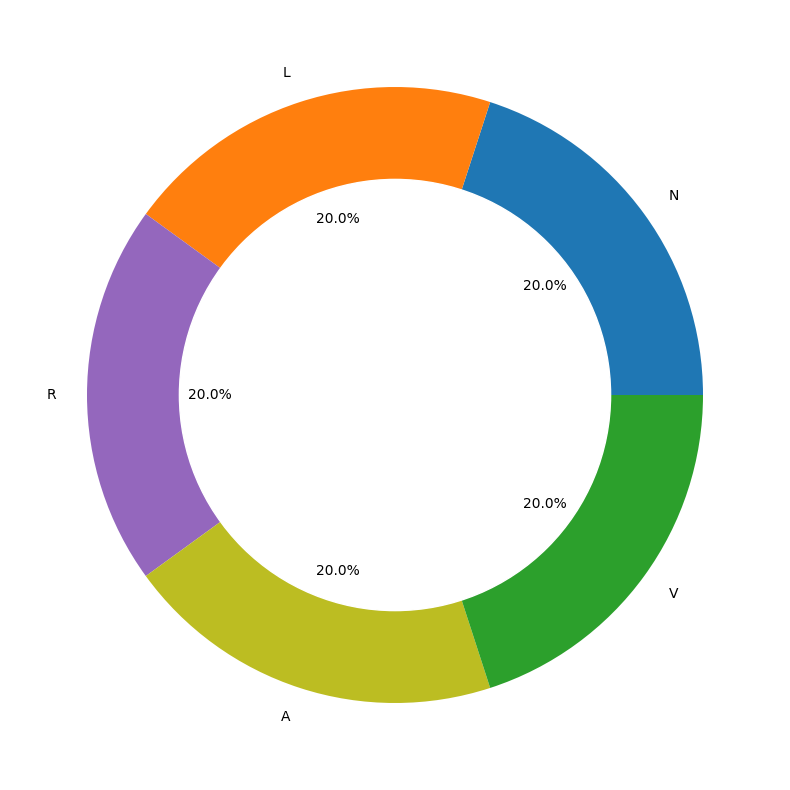

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### 5. Performing Train-Test Split before Training the model

In [ ]:
# Split the original dataset into train and test sets
train, test = train_test_split(X_train_df, test_size=0.20, random_state=42)

# # Further split the training set into train and validation sets
# train, val = train_test_split(train, test_size=0.25, random_state=42)  # 25% of the training set

In [ ]:
# Prepare the target and features for training, validation, and test sets
target_train = train[train.shape[1]-1]
# target_val = val[val.shape[1]-1]
target_test = test[test.shape[1]-1]

train_y = to_categorical(target_train)
# val_y = to_categorical(target_val)
test_y = to_categorical(target_test)

In [ ]:
train_x = train.iloc[:, :train.shape[1]-1].values
# val_x = val.iloc[:, :val.shape[1]-1].values
test_x = test.iloc[:, :test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
# val_x = val_x.reshape(len(val_x), val_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)

In [ ]:
print("Training set:", train_x.shape, train_y.shape)
# print("Validation set:", val_x.shape, val_y.shape)
print("Test set:", test_x.shape, test_y.shape)

Training set: (12000, 360, 1) (12000, 5)
Test set: (3000, 360, 1) (3000, 5)


### 6. Building the Model Architecture


In [ ]:
# Best trial obtained from optuna:
# Value:  0.9386666417121887
#   Params:
#     num_layers: 2
#     num_filters_0: 80
#     num_filters_1: 64
#     kernel_size_0: 5
#     kernel_size_1: 7
#     dropout_rate: 0.3200580062760364
#     batch_size: 96
#     learn_rate: 0.0011611420918167382
#     num_epochs: 30


#### Description of the model and the parameters for each layer

In [ ]:
# Instanciate an empty model
model = Sequential()
model.add(Conv1D(filters=80, kernel_size=5, padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.3200580062760364))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 80)        │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 80)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 64)        │        35,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5696)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5696)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │       199,395 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,959 (921.71 KB)

 Trainable params: 235,959 (921.71 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Performing K-Fold Cross validation (K=5)

In [ ]:
# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Convert your data into NumPy arrays (if not already)
X = np.array(train_x)  # Assuming X_train_df contains features
y = np.array(train_y)  # Assuming y_train_df contains labels

In [ ]:
# Directory to save models
save_dir = "kfold_models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
fold = 1
# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Build and compile your model here
    model = Sequential()
    model.add(Conv1D(filters=80, kernel_size=5, padding='same', activation='relu',input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.3200580062760364))
    model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax())

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.0011611420918167382), metrics=['accuracy'])
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=96, epochs=30,
        verbose=1,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save training history
    history_path = os.path.join(save_dir, f"history_fold_{fold}.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)

    print(f"Training history for fold {fold} saved at: {history_path}")

    # Saving Model
    model_path = os.path.join(save_dir, f"model_fold_{fold}.h5")
    model.save(model_path)
    print(f"Model for fold {fold} saved at: {model_path}")

    fold += 1
    print(f"="*80)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.6706 - loss: 0.8913 - val_accuracy: 0.8979 - val_loss: 0.3428
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.9098 - loss: 0.2989 - val_accuracy: 0.9212 - val_loss: 0.2659
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.9277 - loss: 0.2380 - val_accuracy: 0.9246 - val_loss: 0.2583
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9365 - loss: 0.2146 - val_accuracy: 0.9400 - val_loss: 0.2258
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9459 - loss: 0.1846 - val_accuracy: 0.9388 - val_loss: 0.2462
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9469 - loss: 0.1821 - val_accuracy: 0.9383 - val_loss: 0.2259
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.9545 - loss: 0.1607 - val_accuracy: 0.9388 - val_loss: 0.2236
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9546 - loss: 0

Validation Loss: 0.19810378551483154, Validation Accuracy: 0.9612500071525574
Training history for fold 1 saved at: kfold_models/history_fold_1.json
Model for fold 1 saved at: kfold_models/model_fold_1.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.7081 - loss: 0.8479 - val_accuracy: 0.8900 - val_loss: 0.3672
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.9086 - loss: 0.3036 - val_accuracy: 0.9275 - val_loss: 0.2598
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9292 - loss: 0.2451 - val_accuracy: 0.9367 - val_loss: 0.2230
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9400 - loss: 0.2100 - val_accuracy: 0.9371 - val_loss: 0.2211
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9345 - loss: 0.2201 - val_accuracy: 0.9442 - val_loss: 0.2076
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9415 - loss: 0.1862 - val_accuracy: 0.9408 - val_loss: 0.2106
Epoch 7/3

Validation Loss: 0.15182369947433472, Validation Accuracy: 0.9666666388511658
Training history for fold 2 saved at: kfold_models/history_fold_2.json
Model for fold 2 saved at: kfold_models/model_fold_2.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.6900 - loss: 0.8883 - val_accuracy: 0.9062 - val_loss: 0.3330
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9071 - loss: 0.3166 - val_accuracy: 0.9308 - val_loss: 0.2276
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9246 - loss: 0.2607 - val_accuracy: 0.9375 - val_loss: 0.2168
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9384 - loss: 0.1992 - val_accuracy: 0.9346 - val_loss: 0.2368
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9367 - loss: 0.2113 - val_accuracy: 0.9500 - val_loss: 0.1809
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9497 - loss: 0.1818 - val_accuracy: 0.9504 - val_loss: 0.1782
Epoch 7/3

Validation Loss: 0.1444583237171173, Validation Accuracy: 0.9674999713897705
Training history for fold 3 saved at: kfold_models/history_fold_3.json
Model for fold 3 saved at: kfold_models/model_fold_3.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.6836 - loss: 0.8843 - val_accuracy: 0.9021 - val_loss: 0.3306
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9061 - loss: 0.3195 - val_accuracy: 0.9221 - val_loss: 0.2554
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9228 - loss: 0.2448 - val_accuracy: 0.9321 - val_loss: 0.2349
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9362 - loss: 0.2070 - val_accuracy: 0.9446 - val_loss: 0.1897
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.9400 - loss: 0.1947 - val_accuracy: 0.9425 - val_loss: 0.1998
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.9486 - loss: 0.1702 - val_accuracy: 0.9413 - val_loss: 0.2078
Epoch 7/30

Validation Loss: 0.1319798082113266, Validation Accuracy: 0.9683333039283752
Training history for fold 4 saved at: kfold_models/history_fold_4.json
Model for fold 4 saved at: kfold_models/model_fold_4.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.6774 - loss: 0.8868 - val_accuracy: 0.8967 - val_loss: 0.3419
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.8982 - loss: 0.3492 - val_accuracy: 0.9304 - val_loss: 0.2412
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9195 - loss: 0.2644 - val_accuracy: 0.9471 - val_loss: 0.2000
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9331 - loss: 0.2310 - val_accuracy: 0.9388 - val_loss: 0.1995
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9402 - loss: 0.2084 - val_accuracy: 0.9521 - val_loss: 0.1716
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9406 - loss: 0.1956 - val_accuracy: 0.9567 - val_loss: 0.1507
Epoch 7/30

Validation Loss: 0.12237347662448883, Validation Accuracy: 0.9712499976158142
Training history for fold 5 saved at: kfold_models/history_fold_5.json
Model for fold 5 saved at: kfold_models/model_fold_5.h5


In [ ]:
print("Saving everything to:", os.path.abspath(save_dir))

Saving everything to: /content/kfold_models


In [ ]:
!ls '/content/drive/My Drive/Readymade'

'Classical Feature Extraction Method.ipynb'
 CNN1d_Experiment_01.ipynb
 CNN1d_Experiment_02.ipynb
'Feature Extraction (After Preprocessing and Segmentation).ipynb'
 input
 kfold_models
 optuna-experimentation-sta-221.ipynb
'Preprocessing and Segmentation of ECG.ipynb'
 README.md
 sample_data
'STA_221_Final_Project_Report (1).pdf'
 STA_221_Final_Project_Report.pdf


In [ ]:
!ls '/content/drive/My Drive/Readymade/kfold_models'

history_fold_1.json  history_fold_4.json  model_fold_2.h5  model_fold_5.h5
history_fold_2.json  history_fold_5.json  model_fold_3.h5
history_fold_3.json  model_fold_1.h5	  model_fold_4.h5


In [ ]:
!mv /content/kfold_models /content/drive/My\ Drive/Readymade/
!mv /content/sample_data /content/drive/My\ Drive/Readymade/


In [ ]:
kfold_models = '/content/drive/My Drive/Readymade/kfold_models'


In [ ]:
# Directory where history JSON files are stored
history_dir = kfold_models

# Initialize lists to store metrics for each fold
results = {
    "Fold": [],
    "Train Accuracy": [],
    "Train Loss": [],
    "Validation Accuracy": [],
    "Validation Loss": []
}

# Loop through the JSON files for each fold
for fold in range(1, 6):  # Assuming 5 folds
    history_path = os.path.join(history_dir, f"history_fold_{fold}.json")

    # Load the history file
    with open(history_path, "r") as f:
        history = json.load(f)

    # Extract the final metrics from the history
    train_loss = history["loss"][-1]
    train_acc = history["accuracy"][-1]
    val_loss = history["val_loss"][-1]
    val_acc = history["val_accuracy"][-1]

    # Append the results for the current fold
    results["Fold"].append(fold)
    results["Train Accuracy"].append(train_acc)
    results["Train Loss"].append(train_loss)
    results["Validation Accuracy"].append(val_acc)
    results["Validation Loss"].append(val_loss)

#### Summary of KFolds

In [ ]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

In [ ]:
results_df

,Fold,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,1,0.976875,0.091945,0.961250,0.198104
1,2,0.973750,0.100076,0.966667,0.151824
2,3,0.977604,0.095081,0.967500,0.144458
3,4,0.976979,0.093774,0.968333,0.131980
4,5,0.975417,0.096493,0.971250,0.122373


### 8. Saving KFold models and their training history

In [ ]:
!zip -r output_folder.zip kfold_models

	zip warning: name not matched: kfold_models

zip error: Nothing to do! (try: zip -r output_folder.zip . -i kfold_models)


In [ ]:
!zip -r /content/output_folder.zip "/content/drive/My Drive/Readymade/kfold_models"


  adding: content/drive/My Drive/Readymade/kfold_models/ (stored 0%)
  adding: content/drive/My Drive/Readymade/kfold_models/history_fold_1.json (deflated 56%)
  adding: content/drive/My Drive/Readymade/kfold_models/model_fold_1.h5 (deflated 8%)
  adding: content/drive/My Drive/Readymade/kfold_models/history_fold_2.json (deflated 57%)
  adding: content/drive/My Drive/Readymade/kfold_models/model_fold_2.h5 (deflated 8%)
  adding: content/drive/My Drive/Readymade/kfold_models/history_fold_3.json (deflated 57%)
  adding: content/drive/My Drive/Readymade/kfold_models/model_fold_3.h5 (deflated 7%)
  adding: content/drive/My Drive/Readymade/kfold_models/history_fold_4.json (deflated 57%)
  adding: content/drive/My Drive/Readymade/kfold_models/model_fold_4.h5 (deflated 8%)
  adding: content/drive/My Drive/Readymade/kfold_models/history_fold_5.json (deflated 58%)
  adding: content/drive/My Drive/Readymade/kfold_models/model_fold_5.h5 (deflated 8%)


In [ ]:
!zip -r output_folder.zip . -i kfold_models

Scanning files .........


zip error: Interrupted (aborting)


### 9. Finding the performance on test Data

**Plotting the loss convergence**

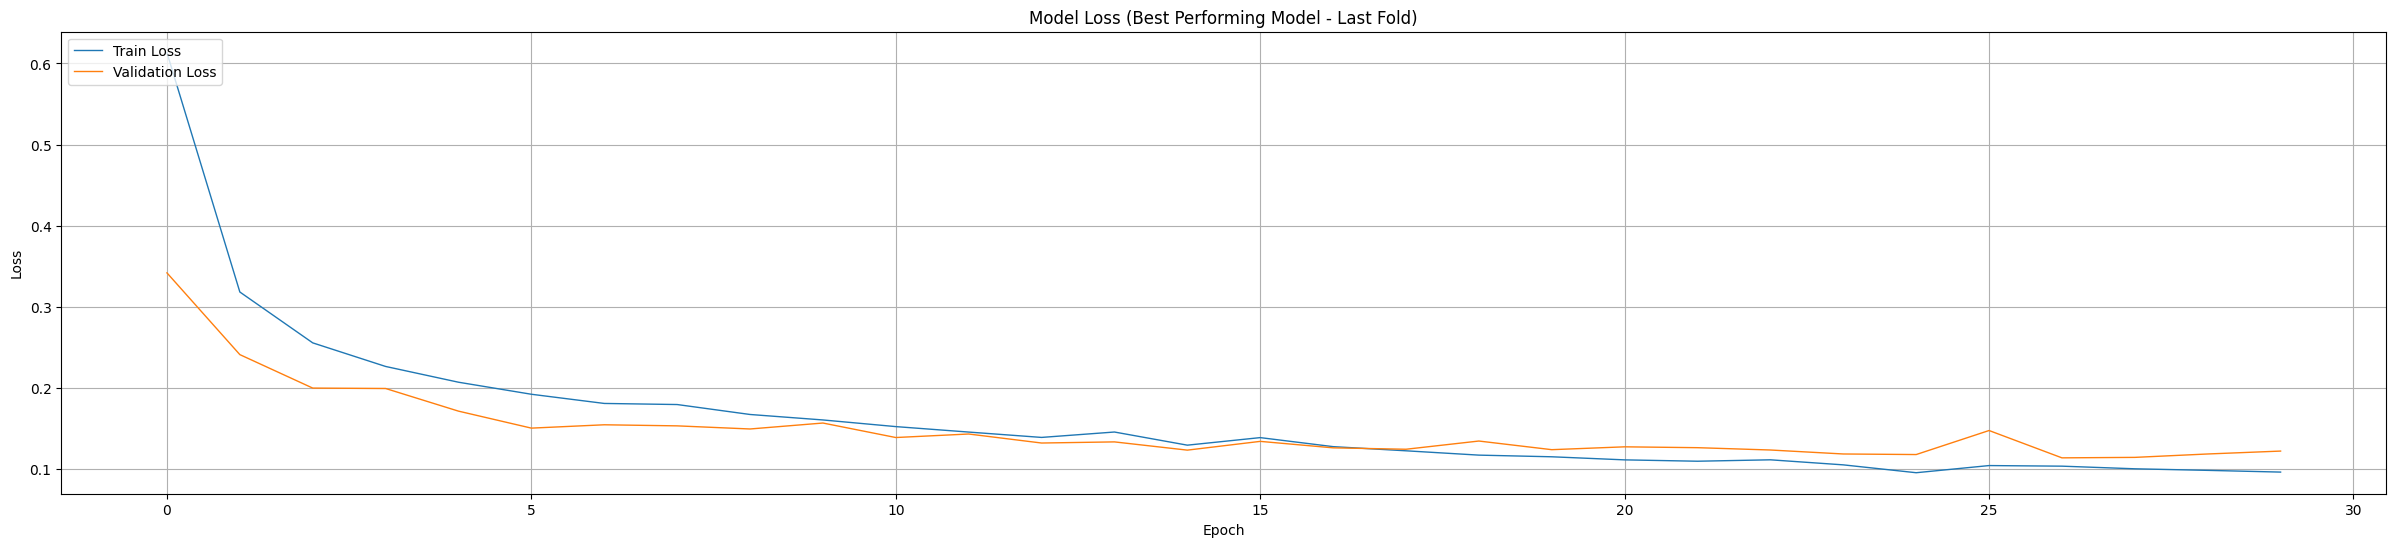

In [ ]:
# Path to the history file for the last fold (best-performing model)
#history_path = "/kaggle/input/output-folder-kfold/kfold_models_all_randomized/history_fold_5.json"  # Update this with the correct file name if needed
history_path = "/content/drive/My Drive/Readymade/kfold_models/history_fold_5.json"

# Load the history file
with open(history_path, "r") as f:
    best_model_history = json.load(f)

# Plot loss
plt.plot(best_model_history['loss'], label='Train Loss')
plt.plot(best_model_history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Best Performing Model - Last Fold)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Plotting accuracy**

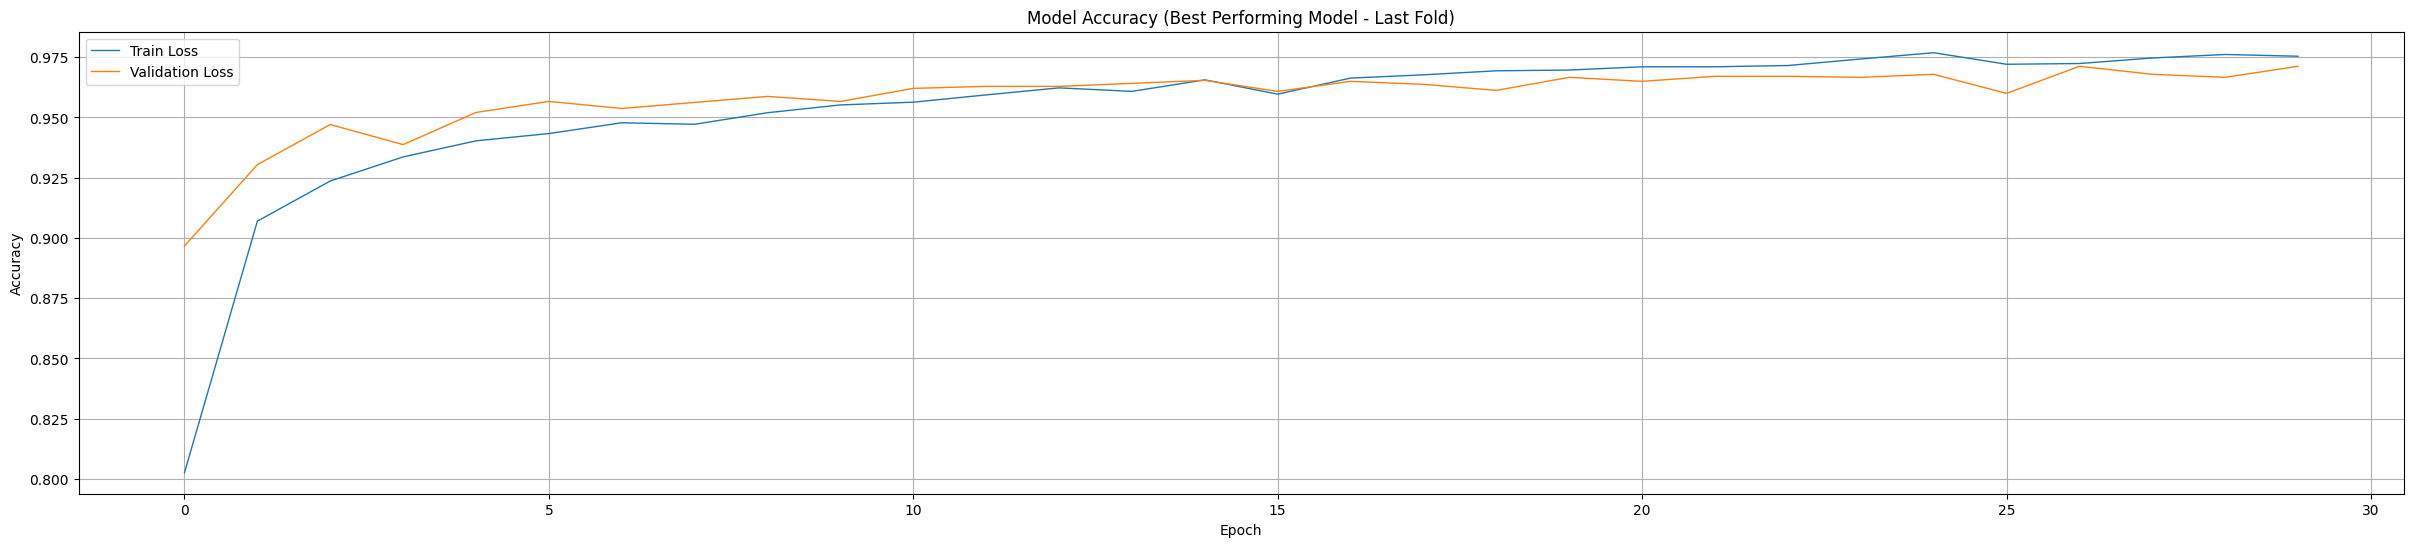

In [ ]:
# Plot loss
plt.plot(best_model_history['accuracy'], label='Train Loss')
plt.plot(best_model_history['val_accuracy'], label='Validation Loss')
plt.title('Model Accuracy (Best Performing Model - Last Fold)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Finding the performance on test Data

In [ ]:
# List to store true labels and predictions from all folds
all_true_labels = []
all_pred_probs = []
all_pred_classes = []

# Number of folds
num_folds = 5  # Adjust as per your k-fold cross-validation

# Iterate through each fold's model
for fold in range(1, num_folds + 1):
    print(f"Evaluating Fold {fold}...")

    # Load the model for the current fold
    #model_path = f"/kaggle/input/output-folder-kfold/kfold_models_all_randomized/model_fold_{fold}.h5"  # Update path as per your folder structure
    model_path = f"/content/drive/My Drive/Readymade/kfold_models/model_fold_{fold}.h5"

    model = load_model(model_path)

    # Predict probabilities for the test data of the current fold
    test_predictions = model.predict(test_x)  # Replace with fold-specific test_x
    predicted_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

    # Append predictions and true labels
    all_pred_probs.append(test_predictions)
    all_pred_classes.append(predicted_classes)
    all_true_labels.append(np.argmax(test_y, axis=1))

Evaluating Fold 1...


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


Evaluating Fold 2...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Evaluating Fold 3...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Evaluating Fold 4...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Evaluating Fold 5...
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [ ]:
# Combine all folds' results
all_pred_probs = np.concatenate(all_pred_probs, axis=0)
all_pred_classes = np.concatenate(all_pred_classes, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# Compute classification report
report = classification_report(all_true_labels, all_pred_classes, digits=2, output_dict=True)

# Compute AUROC and AUPRC
auroc = roc_auc_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, multi_class="ovr")
auprc = average_precision_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, average="macro")

In [ ]:
# Display Results
print("Combined Classification Report Across All Folds:")
for fold_num, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Fold {fold_num}:")
        print(f"Precision={metrics['precision']}")
        print(f"Recall={metrics['recall']}")
        print(f"F1-Score={metrics['f1-score']}")
        print("="*50)


print("\nSummary Metrics Across All Folds:")
print(f"F1 Score (weighted): {report['weighted avg']['f1-score']:.4f}")
print(f"Precision (weighted): {report['weighted avg']['precision']:.4f}")
print(f"Recall (weighted): {report['weighted avg']['recall']:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

Combined Classification Report Across All Folds:
Fold 0:
Precision=0.9403532155948018
Recall=0.9422370617696161
F1-Score=0.9412941961307538
Fold 1:
Precision=0.9838358719303699
Recall=0.9952830188679245
F1-Score=0.9895263404720963
Fold 2:
Precision=0.994074590449634
Recall=0.9937282229965156
F1-Score=0.9939013765464366
Fold 3:
Precision=0.9625850340136054
Recall=0.9449081803005008
F1-Score=0.953664700926706
Fold 4:
Precision=0.9757820383451059
Recall=0.9800675675675675
F1-Score=0.9779201078712287
Fold macro avg:
Precision=0.9713261500667034
Recall=0.9712448103004249
F1-Score=0.9712613443894442
Fold weighted avg:
Precision=0.9712804692271814
Recall=0.9713333333333334
F1-Score=0.9712824086250312

Summary Metrics Across All Folds:
F1 Score (weighted): 0.9713
Precision (weighted): 0.9713
Recall (weighted): 0.9713
AUROC: 0.9979
AUPRC: 0.9925


In [ ]:
overall_accuracy = accuracy_score(all_true_labels, all_pred_classes)
print(f"Overall Accuracy: {overall_accuracy}")

Overall Accuracy: 0.9713333333333334


#### Class-wise accuracy

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming all_true_labels and all_pred_classes are your true and predicted labels
conf_matrix = confusion_matrix(all_true_labels, all_pred_classes)

# Compute class-wise accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print class-wise accuracies
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} Accuracy: {acc:.4f}")


Class 0 Accuracy: 0.9422
Class 1 Accuracy: 0.9953
Class 2 Accuracy: 0.9937
Class 3 Accuracy: 0.9449
Class 4 Accuracy: 0.9801


In [ ]:
for i, layer in enumerate(best_model.layers):
    print(f"{i}: {layer.name} — {layer.__class__.__name__}")

0: conv1d_10 — Conv1D
1: average_pooling1d_10 — AveragePooling1D
2: conv1d_11 — Conv1D
3: average_pooling1d_11 — AveragePooling1D
4: flatten_5 — Flatten
5: dropout_5 — Dropout
6: dense_10 — Dense
7: dense_11 — Dense
8: softmax_5 — Softmax


In [ ]:
from IPython.display import display, Latex

display(Latex(r'''
\begin{array}{|l|c|c|}
\hline
\textbf{Task} & \textbf{Kaggle Dataset} & \textbf{PhysioNet WFDB} \\
\hline
Format & \text{CSV} & \texttt{.dat, .hea, .atr} \\
\hline
Annotation Reading & \texttt{open(file).readlines()} & \texttt{wfdb.rdann()} \\
\hline
Signal Reading & \texttt{numpy.load()} \text{ or } \texttt{open()} & \texttt{wfdb.rdrecord()} \\
\hline
Can use your code as-is? & \text{Yes} & \text{No} \\
\hline
Adapted version possible? & \text{Yes} & \text{Yes (with wfdb)} \\
\hline
\end{array}
'''))


<IPython.core.display.Latex object>